In [100]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [101]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
mode = 'theory' #'sim' or 'theory'
if mode == 'theory':
    n_seeds = 1
    PR_D_1 = list(np.round(np.arange(0.05, 1.05, 0.05), 2))
    PR_D_2 = list(np.round(np.arange(1.5, 10.5, 0.5), 2))
    macro_configs = config_generator(PR_D=PR_D_1+PR_D_2,
                                     g=[3, 6, 10])
if mode == 'sim':
    n_seeds = 10
    PR_D_1 = list(np.round(np.arange(0.1, 1.1, 0.1), 2))
    PR_D_2 = [3, 10]
    macro_configs = config_generator(PR_D=PR_D_1+PR_D_2,
                                     g=[3, 6, 10])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [8]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
g = params['g']
#g = 6
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)

#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [102]:
### --- Estimate psi empirically --- ###

#Generate LDRG matrix

alpha = 1
if params['PR_D'] >= 1:
    alpha = params['PR_D']
    PR_D = 1
else:
    PR_D = params['PR_D']
K = int(alpha * N)
rho = np.zeros(K)
X1 = np.random.normal(0, 1, (N, K))
X2 = np.random.normal(0, 1, (N, K))
Y = np.random.normal(0, 1, (N, K))
L = np.sqrt((1 - rho)/N)*X1 + np.sqrt(rho/N)*Y
RT = (np.sqrt((1 - rho)/N)*X2 + np.sqrt(rho/N)*Y).T

if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(K)/K)
else:
    D = np.ones(K)
    
#PR_G = params['PR_G']
PR_G = 1
if PR_G < 1:
    beta_G = invert_PR_by_newton(PR_G)
    G = np.exp(-beta_G*np.arange(N)/N)
else:
    G = np.ones(N)

g_correction = g / np.sqrt(np.sum(D**2)/N*np.sum(G**2)/N)
D = D * g_correction

L = torch.from_numpy(L).type(torch.FloatTensor).to(0)
D_ = torch.from_numpy(D).type(torch.FloatTensor).to(0)
RT = torch.from_numpy(RT).type(torch.FloatTensor).to(0)
G_ = torch.from_numpy(G).type(torch.FloatTensor).to(0)

W = torch.einsum('ik, k, kj, j -> ij', L, D_, RT, G_)
del L
del RT

In [10]:
### --- Estimate psi empirically --- ###

compute_empirical_psi = (mode == 'sim')
if compute_empirical_psi:
    W_ = W
    Psi = estimate_psi(lags_emp, T_sim=2000, dt_save=dT_emp, dt=0.05, r_weights=None,
                       W=W_, phi_torch=phi_torch, T_save_delay=1000, N_batch=1, N_loops=100,
                       runga_kutta=True)

    #symmetrize psi for comparison
    Psi = Psi.cpu().detach().numpy()
    Psi_emp = np.concatenate([Psi[-n_lags_emp:][::-1], Psi[1:n_lags_emp]])
    lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])
else:
    lags_emp_full = np.concatenate([-lags_emp[-n_lags_emp:][::-1], lags_emp[1:n_lags_emp]])
    Psi_emp = np.zeros_like(lags_emp_full)

In [135]:
### --- Set theory parameters --- ###
#T_window = 200
#dT = 0.025
T_window = 100
dT = 0.5
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

In [136]:
### --- Compute single-unit properties
g = 6
d = compute_Delta_0(g=g)
time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
Delta_T = fix(Delta_T)
C_Phi_half = compute_C_simple(d, Delta_T)
avg_gain = compute_phi_prime_avg(d)

In [163]:
### --- Compute Psi from theory --- ###

#Define relevant single-unit functions
C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                        C_Phi_half[1:n_lags],
                        np.array([C_Phi_half[-1]])])
C_phi_omega = fft(C_phi, dT)
T = len(C_phi)
t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
sampfreq = 1/dT
w = 2*np.pi*sampfreq*t_indices/T
C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

#Compute PRs
#PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
#PR_D = (np.sum(D**2))**2/np.sum(D**4)/K
#PR_G = 1
#PR_D = 1
PR_D = 1
PR_G = 1

#Compute psi of normalized units for LDRG network
num = 1 + (1/(alpha*PR_D) + 1/PR_G - 1)*np.abs(2*np.pi*g**2 * S_phi_S_phi)**2
denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
Psi_omega1_omega2 = (num / denom) * C_phi_C_phi #INCLUDING THE ON-DIAGONALS
Psi_om1_om2_1 = 1 / denom * C_phi_C_phi
Psi_om1_om2_2 = (num - 1) / denom * C_phi_C_phi
Psi_t1_t2_1 = ifft(Psi_om1_om2_1, dT)
Psi_t1_t2_2 = ifft(Psi_om1_om2_2, dT)
Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
Psi_tau_tau = np.diag(Psi_tau1_tau2)
Psi_tau_0 = Psi_tau1_tau2[:,T//2]

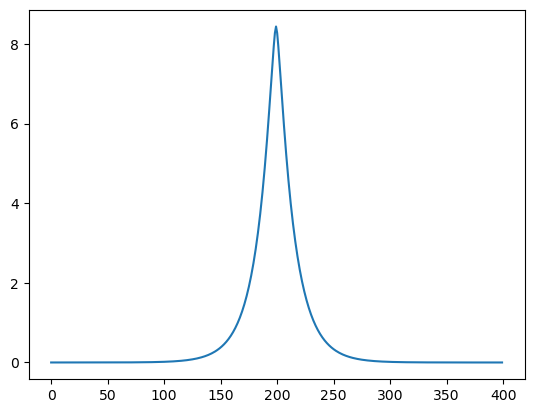

In [164]:
plt.plot(np.diag(Psi_t1_t2_1))
#plt.plot(np.diag(Psi_t1_t2_2))
#plt.plot(np.diag(Psi_t1_t2_1) + np.diag(Psi_t1_t2_2))
#plt.plot(Psi_tau_tau)

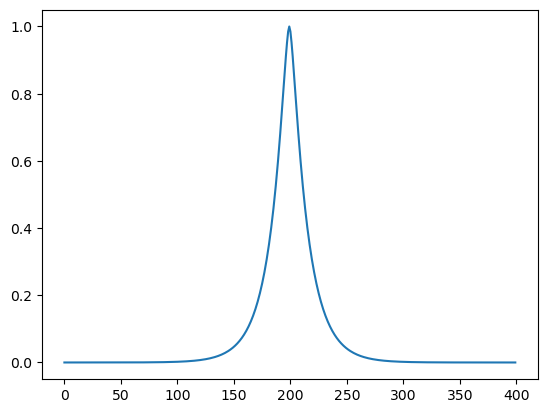

In [165]:
plt.plot(Psi_tau_tau/np.amax(Psi_tau_tau))

In [31]:
processed_data = np.array([Psi_tau_tau, Psi_tau_0, C_phi])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [105]:
###Truncate file above
file_name = 'LDRG_timescales'
job_name = 'LDRG_PRD_timescales'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook LDRG_timescales.ipynb to script
[NbConvertApp] Writing 14186 bytes to LDRG_timescales.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b745b8d9b50> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b745b8d9b50> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [106]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name),
               mem=64, n_hours=24, n_gpus=1,
               results_subdir='misc')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False, results_subdir='misc')

sending incremental file list

sent 1,823 bytes  received 30 bytes  3,706.00 bytes/sec
total size is 450,081  speedup is 242.89
sbatch  --array=1-114 -A lkumar -p lkumar /home/om2382/low-rank-dims/job_scripts/LDRG_PRD_timescales.s


In [120]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3536319    lkumar  jupyter   om2382  R    4:29:15      1 ax15


In [121]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDRG_PRD_timescales'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='misc')

/home/om2382/mft-theory/cluster/submit_jobs.py:219: ComplexWarning: Casting complex values to real discards the imaginary part
  results_array[index] = result['processed_data']


In [26]:
job_name = 'LDRG_PR_match_PRD_sim_test'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [47]:
theory_results[1].shape

(138, 3, 1, 3, 16000)

In [129]:
theory_results[0]

{'PR_D': [0.05,
  0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6,
  0.65,
  0.7,
  0.75,
  0.8,
  0.85,
  0.9,
  0.95,
  1.0,
  1.5,
  2.0,
  2.5,
  3.0,
  3.5,
  4.0,
  4.5,
  5.0,
  5.5,
  6.0,
  6.5,
  7.0,
  7.5,
  8.0,
  8.5,
  9.0,
  9.5,
  10.0],
 'g': [3, 6, 10],
 'i_seed': [0]}

Text(0.5, 1.0, 'not normalized')

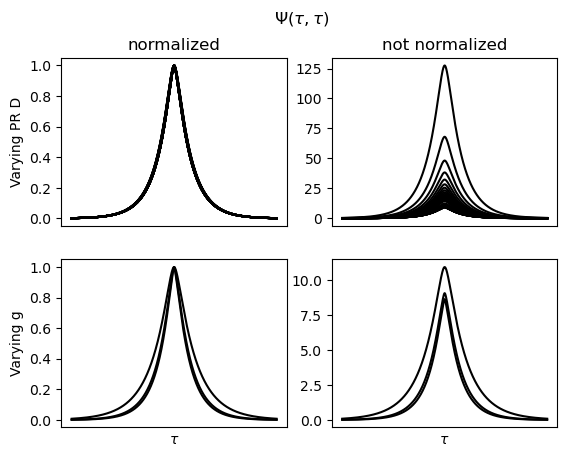

In [128]:
fig, ax = plt.subplots(2, 2)
for i_PRD, PR in enumerate(theory_results[0]['PR_D']):
    s = theory_results[1][i_PRD,1,0,0,6000:-6000]
    ax[0,0].plot(s/np.amax(s), color='k')
    ax[0,1].plot(s, color='k')
for i_g, g in enumerate(theory_results[0]['g']):
    s = theory_results[1][30,i_g,0,0,6000:-6000]
    ax[1,0].plot(s/np.amax(s), color='k')
    ax[1,1].plot(s, color='k')
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
ax[1,1].set_xlabel(r'$\tau$')
ax[1,0].set_xlabel(r'$\tau$')
ax[0,0].set_ylabel('Varying PR D')
ax[1,0].set_ylabel('Varying g')
fig.suptitle(r'$\Psi(\tau, \tau)$')
ax[0,0].set_title('normalized')
ax[0,1].set_title('not normalized')

Text(0.5, 1.0, 'not normalized')

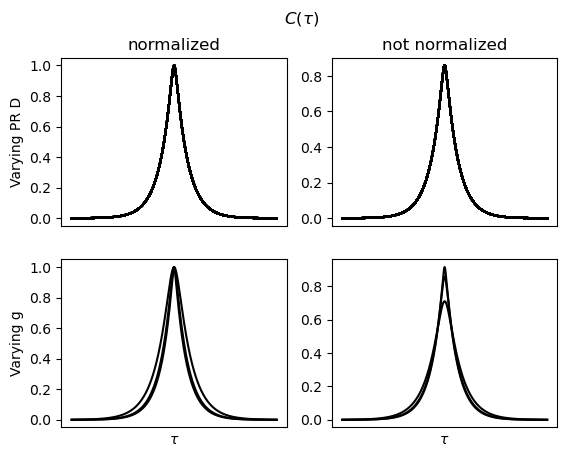

In [85]:
fig, ax = plt.subplots(2, 2)
for i_PRD, PR in enumerate(theory_results[0]['PR_D']):
    s = theory_results[1][i_PRD,1,0,2,7000:-7000]
    ax[0,0].plot(s/np.amax(s), color='k')
    ax[0,1].plot(s, color='k')
for i_g, g in enumerate(theory_results[0]['g']):
    s = theory_results[1][78,i_g,0,2,7000:-7000]
    ax[1,0].plot(s/np.amax(s), color='k')
    ax[1,1].plot(s, color='k')
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
ax[1,1].set_xlabel(r'$\tau$')
ax[1,0].set_xlabel(r'$\tau$')
ax[0,0].set_ylabel('Varying PR D')
ax[1,0].set_ylabel('Varying g')
fig.suptitle(r'$C(\tau)$')
ax[0,0].set_title('normalized')
ax[0,1].set_title('not normalized')

In [166]:
def get_component_curves(g, PR_D):
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    avg_gain = compute_phi_prime_avg(d)
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute PRs
    #PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
    #PR_D = (np.sum(D**2))**2/np.sum(D**4)/K
    #PR_G = 1
    #PR_D = 1
    #PR_D = 1
    #PR_G = 1
    PR_G = 1

    #Compute psi of normalized units for LDRG network
    num = 1 + (1/(alpha*PR_D) + 1/PR_G - 1)*np.abs(2*np.pi*g**2 * S_phi_S_phi)**2
    denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
    Psi_omega1_omega2 = (num / denom) * C_phi_C_phi #INCLUDING THE ON-DIAGONALS
    Psi_om1_om2_1 = 1 / denom * C_phi_C_phi
    Psi_om1_om2_2 = (num - 1) / denom * C_phi_C_phi
    Psi_t1_t2_1 = ifft(Psi_om1_om2_1, dT)
    Psi_t1_t2_2 = ifft(Psi_om1_om2_2, dT)
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
    Psi_tau_tau = np.diag(Psi_tau1_tau2)
    Psi_tau_0 = Psi_tau1_tau2[:,T//2]
    
    return np.diag(Psi_t1_t2_1), np.diag(Psi_t1_t2_2)

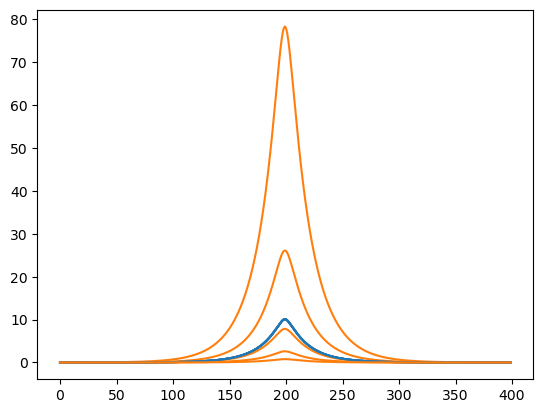

In [181]:
for PR_D in [0.1, 0.3, 1, 3, 10]:
    p1, p2 = get_component_curves(g=3, PR_D=PR_D)
    plt.plot(np.abs(p1), color='C0')
    plt.plot(np.abs(p2), color='C1')
    #plt.plot(np.abs(p1 + p2), color='C2')
    #plt.plot(100*(p1 + p2)/np.amax(p1 + p2), color='C5')

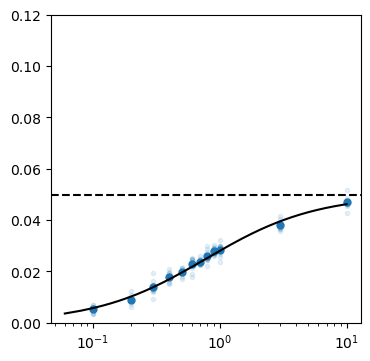

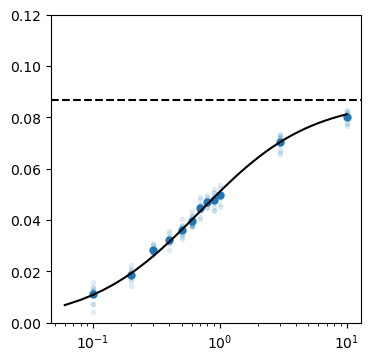

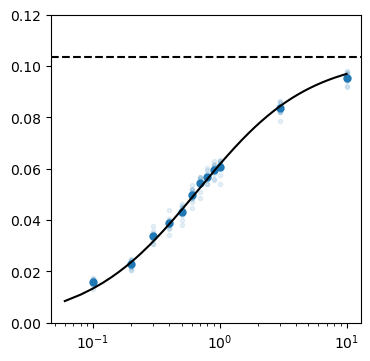

In [24]:
for i_g, g in enumerate(sim_results[0]['g']):
    plt.figure(figsize=(4, 4))
    for k in range(10):
        pass
        plt.plot(sim_results[0]['PR_D'], sim_results[1][:,i_g,k,0], '.', color='C0', alpha=0.1)
    plt.plot(sim_results[0]['PR_D'], sim_results[1][:,i_g,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
    plt.plot(theory_results[0]['PR_D'], theory_results[1][:,i_g,0,1], color='k')
    plt.axhline(y=iid_dim_theory[i_g], color='k', linestyle='--')
    plt.ylim([0, 0.12])
    #plt.xlim([0, 1])
    plt.xscale('log')

In [21]:
### --- Set theory parameters --- ###

iid_dim_theory = np.zeros(len(sim_results[0]['g']))
for i_g, g in enumerate(sim_results[0]['g']):
    T_window = 200
    dT = 0.025
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    lags = np.arange(0, T_window, dT)
    n_lags = int(T_window/dT)
    lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

    ### --- Compute single-unit properties

    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    avg_gain = compute_phi_prime_avg(d)

    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi of normalized units for IID network
    num = 1
    denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
    Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)
    Psi_tau_tau = np.diag(Psi_tau1_tau2)

    C2 = C_Phi_half[0]**2
    iid_dim_theory[i_g] = C2/(C2 + np.amax(np.abs(Psi_tau_tau)))

In [28]:
with open('packaged_results/LDRG_PR_match_PRD_iid_theory_2', 'wb') as f:
    pickle.dump({'g=[3,6,10]_PR_phi': iid_dim_theory}, f)

In [ ]:
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,0], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
plt.ylim([0, 0.1])
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,2], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,2].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')
plt.ylim([0, 0.1])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['alpha'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['alpha'], results_array[:,0,1], color='k')
plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
#plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,2].mean(-1)
sem_pr = results_array[:,:,2].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,2],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])